In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from os import listdir

print(listdir('/kaggle/input/'))

['skin-cancer-malignant-vs-benign']


In [3]:
#Defining the file path for the dataset
f_path='/kaggle/input/skin-cancer-malignant-vs-benign/'

In [5]:
# Loading the dataset
from torchvision import datasets,transforms

transform=transforms.Compose([transforms.Resize(225),transforms.CenterCrop(224),
                             transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset=datasets.ImageFolder(f_path+'train/',transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=32,shuffle=True)
testset=datasets.ImageFolder(f_path+'test/',transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=32,shuffle=True)
trainiter=iter(trainloader)
testiter=iter(testloader)
classes=['benign','malignant']

In [6]:
# Defining a function to show images
def imshow(img):
    img=img/2+0.5
    plt.imshow(np.transpose(img,(1,2,0)))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


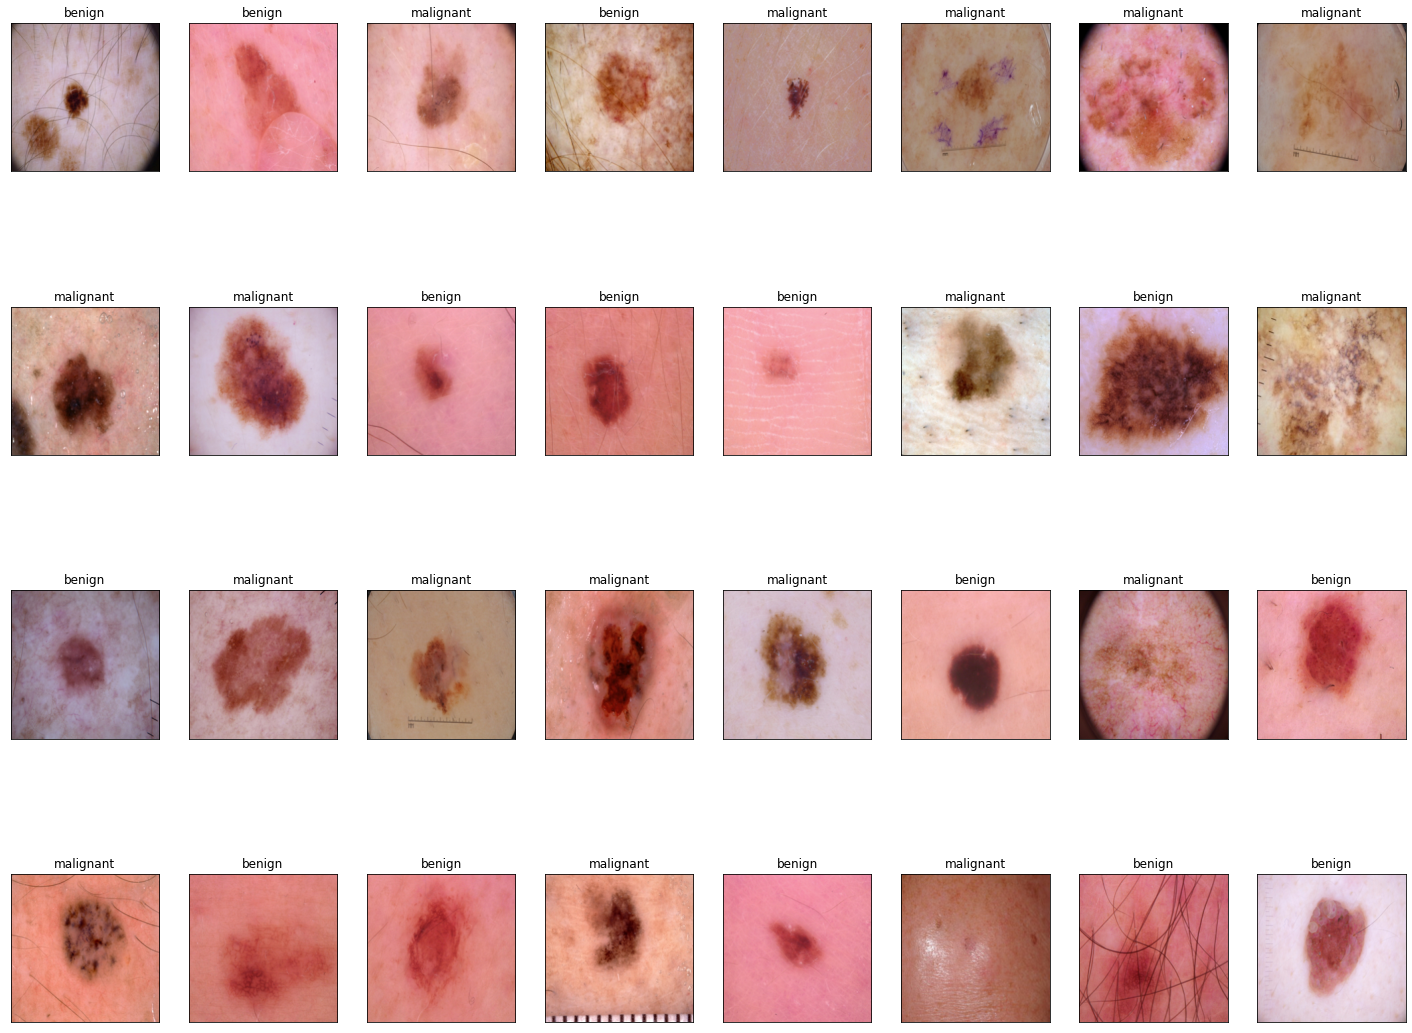

In [7]:
# Plotting some images
images,labels=next(trainiter)
images=images.numpy()
fig=plt.figure(figsize=(25,20))
for i in range(32):
    ax=fig.add_subplot(4,32/4,i+1,yticks=[],xticks=[])
    imshow(images[i])
    ax.set_title(classes[labels[i].item()])

In [8]:
# Importing libraries for Designing the model

from torch import nn
import torch.nn.functional as F
from torch import optim
from torchvision import models

In [13]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [17]:
# Load a pretrained model (RESNET 18) and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features

In [18]:
# Checking the model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
#Freezing the model
for param in model.parameters():
    param.requires_grad = False


In [20]:
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs,2 )

In [21]:
# Checking the model architecture
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# Defining loss function and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001, momentum=0.9)

In [27]:
if train_on_gpu:
    model=model.cuda()

In [30]:
# number of epochs to train the model
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data).cuda()
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(testloader.sampler)
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.332241 	Validation Loss: 0.341656
Validation loss decreased (inf --> 0.341656).  Saving model ...
Epoch: 2 	Training Loss: 0.329769 	Validation Loss: 0.355836
Epoch: 3 	Training Loss: 0.324500 	Validation Loss: 0.332942
Validation loss decreased (0.341656 --> 0.332942).  Saving model ...
Epoch: 4 	Training Loss: 0.320371 	Validation Loss: 0.342299
Epoch: 5 	Training Loss: 0.316594 	Validation Loss: 0.336418
Epoch: 6 	Training Loss: 0.328295 	Validation Loss: 0.342779
Epoch: 7 	Training Loss: 0.291626 	Validation Loss: 0.334823
Epoch: 8 	Training Loss: 0.297619 	Validation Loss: 0.337603
Epoch: 9 	Training Loss: 0.289628 	Validation Loss: 0.327967
Validation loss decreased (0.332942 --> 0.327967).  Saving model ...
Epoch: 10 	Training Loss: 0.301334 	Validation Loss: 0.329111
Epoch: 11 	Training Loss: 0.314170 	Validation Loss: 0.338255
Epoch: 12 	Training Loss: 0.285752 	Validation Loss: 0.329884
Epoch: 13 	Training Loss: 0.283879 	Validation Loss: 0.374070
E

In [31]:
torch.save(model,'cancer_model.pth')

In [33]:
m1=torch.load('cancer_model.pth')

In [35]:
train_on_gpu

True

In [36]:
with torch.no_grad():
    accuracy=0
    for images, labels in testloader:
        if train_on_gpu:
            images,labels = images.cuda() , labels.cuda()
        ps = model(images)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
accuracy_avg=accuracy/len(testloader)
print(f'The overall accuracy of the model: {accuracy_avg*100}%')

The overall accuracy of the model: 84.70238494873047%
